# Домашнее задание №4

## 1. Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

*   f.sigmoid заменил на torch.sigmoid
*   после bicubic интерполяции картинки добавил clamp(min=0, max=1) для исключения выхода за границы диапазона 0...1
*   learning_rate заменил 10^-10 на 0.001 
*   значения в масках теперь в диапазоне 0...1 вместо 0...255 чтобы DiceLoss корректно работал
*   добавлен вывод данных в процессе обучения
*   добавлена проверка работы модели на тестовом датасете




### Подключение библиотек и загрузка датасета

In [1]:
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np
import torchvision.transforms as transforms

In [2]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 245kB 14.8MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12420 sha256=0933c96794d1679a4c16aeb627faf60b4df63775bd1a2dd2ced16ba7180373b3
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=137400831690239e53e2985ed79c12276d5a5fba16c7285791c198f942a8a42f
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip /content/lyft-udacity-challenge.zip -d /content/'Semantic segmentation for Self-driving Cars'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_004.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_005.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_014.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_015.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_024.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_025.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_034.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_035.png  
  inflating: /content/Semantic segmentation for Self-driving Cars/datac/dataC/CameraSeg/02_00_044.pn

Найдем уникальные значения пискселей на картинке, и каждое такое значение будет соответсвовать целому классу.

In [5]:
np.unique(plt.imread('Semantic segmentation for Self-driving Cars/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

В итоге видим, что у нас 13 классов. Вы можете самостоятельно поотображать семантическую маску 
для каждого класса используя код ниже:

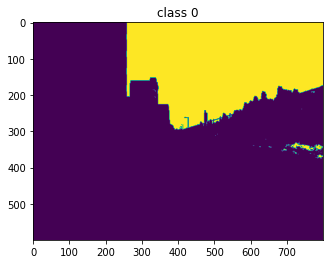

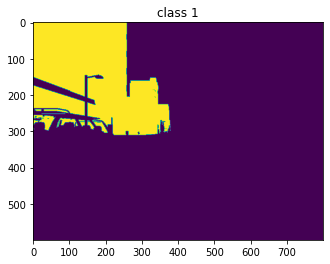

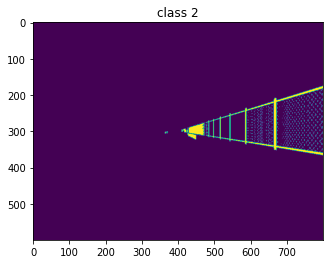

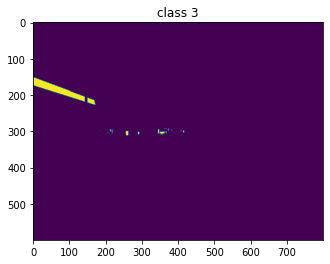

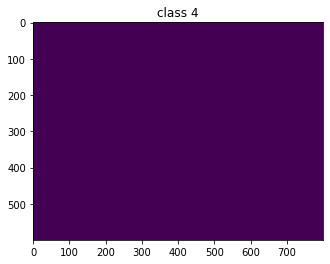

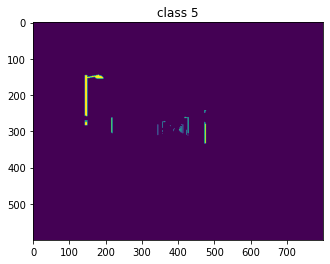

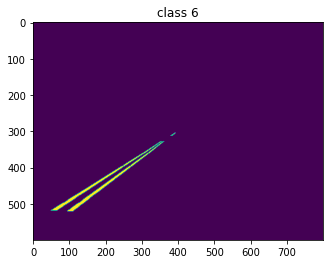

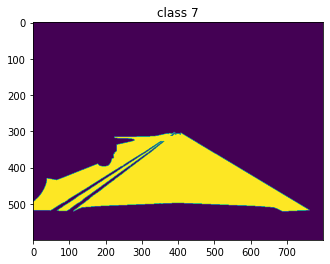

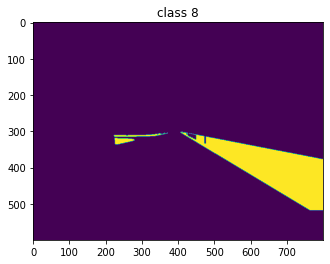

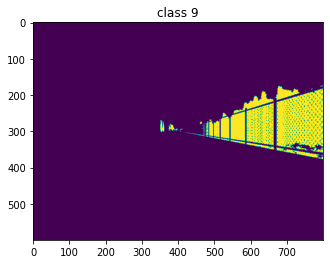

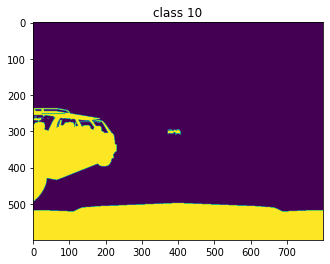

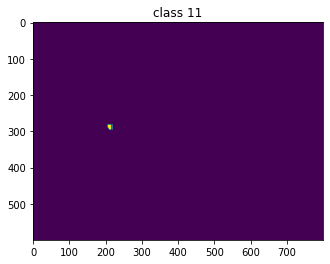

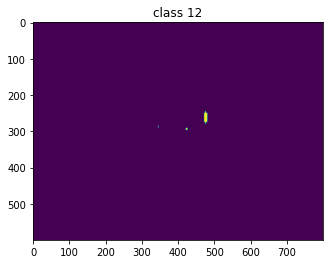

In [6]:
for i in range(13):
    mask = plt.imread('Semantic segmentation for Self-driving Cars/dataA/dataA/CameraSeg/02_00_000.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

Но а я лишь скажу что наши классы называются следующим образом и идут в таком порядке:

In [7]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

### Подгтовка датасета



Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка с rgb картинками и seg.

In [8]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('Semantic segmentation for Self-driving Cars'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

Теперь завернем эти два списка в DataFrame из библиотеки pandas.
В итоге выведем первые пять записей из получившегося датафрейма:

In [9]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# благодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                           cameraRGB                                          cameraSeg
0  Semantic segmentation for Self-driving Cars/da...  Semantic segmentation for Self-driving Cars/da...
1  Semantic segmentation for Self-driving Cars/da...  Semantic segmentation for Self-driving Cars/da...
2  Semantic segmentation for Self-driving Cars/da...  Semantic segmentation for Self-driving Cars/da...
3  Semantic segmentation for Self-driving Cars/da...  Semantic segmentation for Self-driving Cars/da...
4  Semantic segmentation for Self-driving Cars/da...  Semantic segmentation for Self-driving Cars/da...


### Создание класса для датасета

In [10]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 1, 0)).unsqueeze(0) # нормировка маски [0, 1]
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 1, 0)                           # нормировка маски [0, 1]
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [11]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:

In [31]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=8,shuffle=False)

### Проверка работы загрузчика данных

In [13]:
loader = iter(train_data_loader)
img, mask = loader.next()

In [14]:
img.shape

torch.Size([1, 1, 3, 256, 256])

In [15]:
mask.shape

torch.Size([1, 1, 13, 256, 256])

In [16]:
mask[0].shape

torch.Size([1, 13, 256, 256])

In [17]:
# Все маски отнормированы
np.unique(mask)

array([0., 1.], dtype=float32)

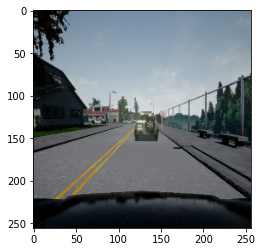

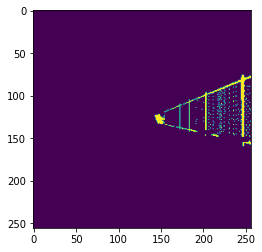

In [18]:
plt.imshow((img[0][0]).permute(1, 2, 0)) # Сама картинка
plt.show()
plt.imshow((mask[0][0][2])) # Второй класс
plt.show()

### Описане класса модели

In [19]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

### Обучение

У нас есть готовые данные и определенная сеть, которую мы хотим обучить. Пришло время построить базовый обучающий конвейер.

Определим скорость обучения и количество эпох:

In [20]:
learning_rate = 0.001
epochs = 1

Выберем устройство,на котором будем обучать нашу модель:

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Определим нашу модель Unet для 13 классов:

In [53]:
# Создание собственной модели
Umodel = UNet(num_classes=13).to(device)

In [22]:
# Создание модели из segmentation_models_pytorch
Umodel = smp.Unet('mobilenet_v2', 
                  classes=13, 
                  encoder_weights='imagenet').to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [23]:
img = img.to(device)

In [24]:
res = Umodel(img[0])

In [25]:
res.shape

torch.Size([1, 13, 256, 256])

Под обучением мы понимаем скармливание целевой функции оптимизирующей функции. Поэтому выберем оптимизирующую функцию и функцию потерь (целевая функция):

In [26]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [27]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [28]:
criterion = SoftDiceLoss()

Определим количество шагов внутри одной эпохи:

In [29]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 7000 total_steps per epoch


Запускаем сам процесс обучения:

Train Epoch: 1, Loss: 0.2630313295125961
Spend time for 300 images: 146.98555636405945 sec


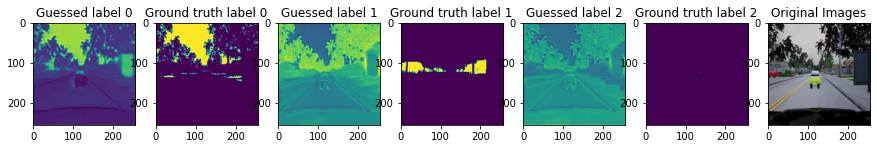

Train Epoch: 1, Loss: 0.1451328541835149
Spend time for 300 images: 150.27250957489014 sec


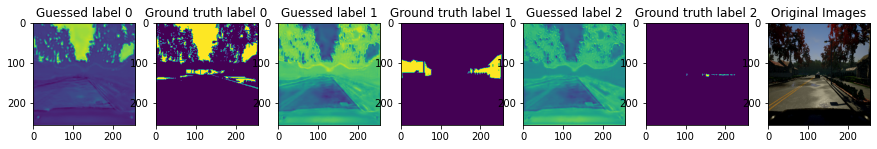

Train Epoch: 1, Loss: 0.12807709574699402
Spend time for 300 images: 149.15615105628967 sec


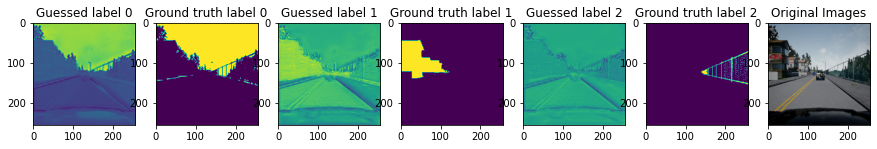

Train Epoch: 1, Loss: 0.10906209091345469
Spend time for 300 images: 149.27412509918213 sec


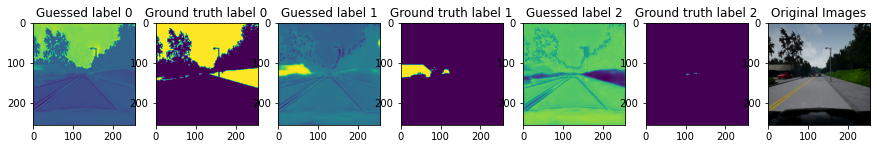

Train Epoch: 1, Loss: 0.08845581372578938
Spend time for 300 images: 148.90603733062744 sec


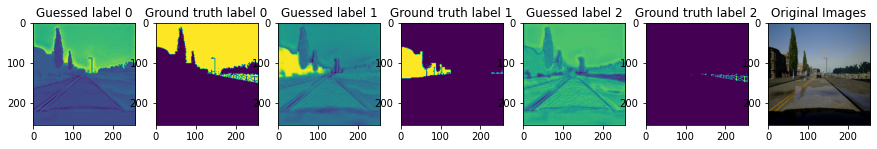

Train Epoch: 1, Loss: 0.07634066979090373
Spend time for 300 images: 148.2164511680603 sec


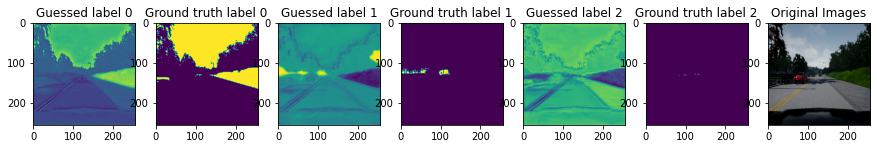

Train Epoch: 1, Loss: 0.07083783328533172
Spend time for 300 images: 150.12177181243896 sec


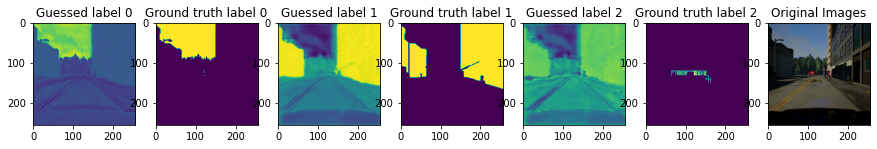

Train Epoch: 1, Loss: 0.0696897409359614
Spend time for 300 images: 149.47262263298035 sec


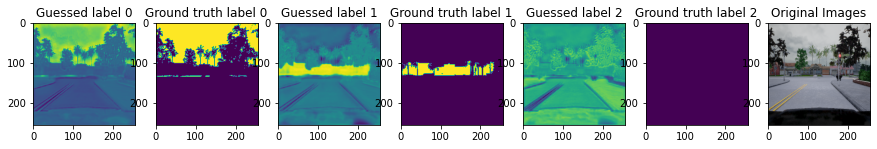

Train Epoch: 1, Loss: 0.06655636608600617
Spend time for 300 images: 150.070378780365 sec


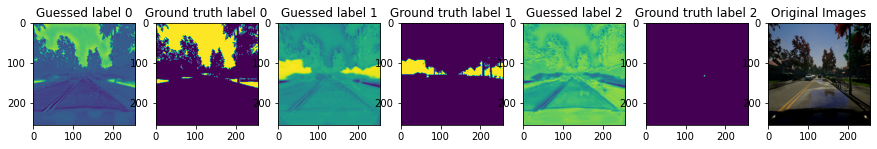

Train Epoch: 1, Loss: 0.07241394937038421
Spend time for 300 images: 148.29170083999634 sec


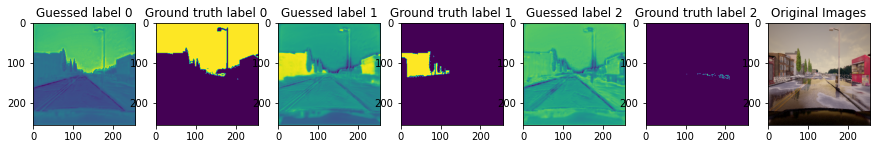

Train Epoch: 1, Loss: 0.06493834137916565
Spend time for 300 images: 149.4237139225006 sec


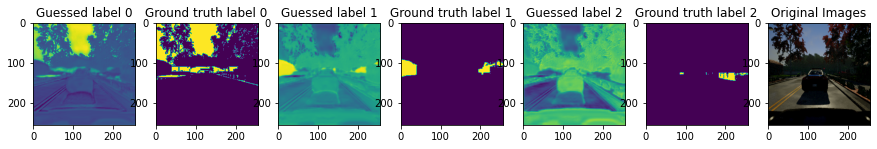

Train Epoch: 1, Loss: 0.06293459018071493
Spend time for 300 images: 149.1710023880005 sec


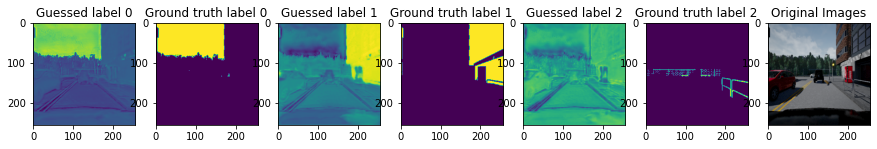

Train Epoch: 1, Loss: 0.06358641505241394
Spend time for 300 images: 148.05723786354065 sec


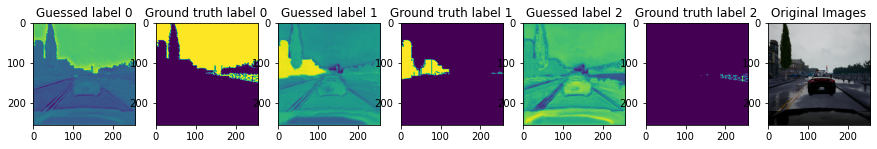

Train Epoch: 1, Loss: 0.06507900695006053
Spend time for 300 images: 149.1509976387024 sec


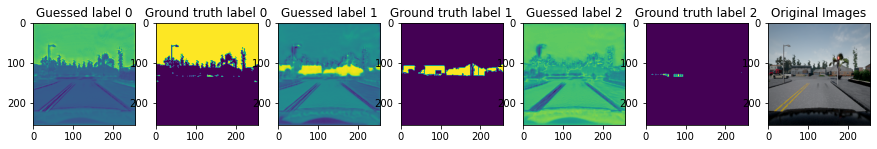

Train Epoch: 1, Loss: 0.06129067341486613
Spend time for 300 images: 150.06386828422546 sec


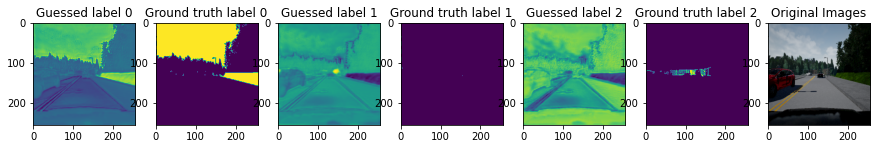

Train Epoch: 1, Loss: 0.06311564405759175
Spend time for 300 images: 149.17101621627808 sec


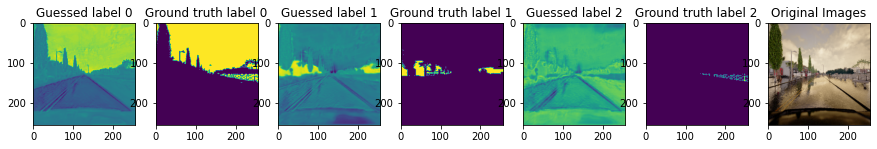

Train Epoch: 1, Loss: 0.05858274936676025
Spend time for 300 images: 148.70339560508728 sec


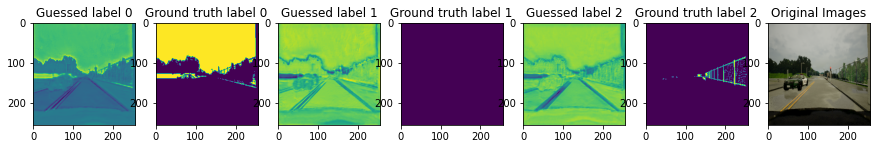

Train Epoch: 1, Loss: 0.05949470142523448
Spend time for 300 images: 148.03185200691223 sec


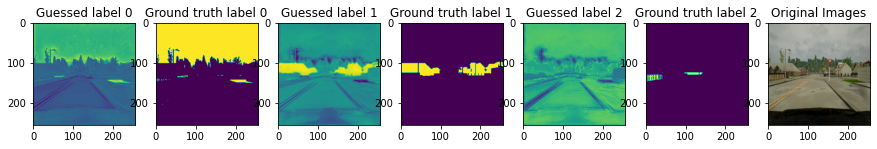

Train Epoch: 1, Loss: 0.05826075971126556
Spend time for 300 images: 147.68707966804504 sec


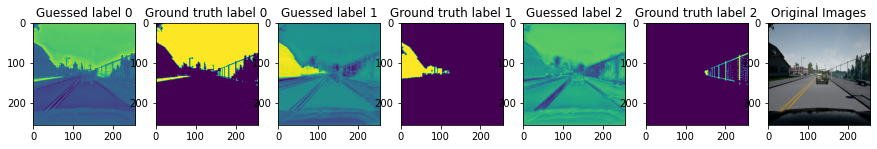

Train Epoch: 1, Loss: 0.061091145674387615
Spend time for 300 images: 146.37027311325073 sec


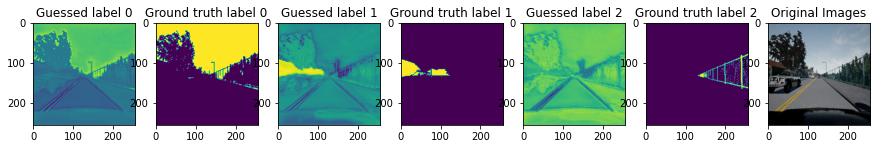

Train Epoch: 1, Loss: 0.05909687141577403
Spend time for 300 images: 147.5522289276123 sec


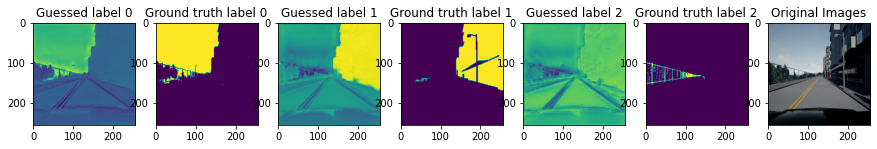

Train Epoch: 1, Loss: 0.05662514368693034
Spend time for 300 images: 147.88278579711914 sec


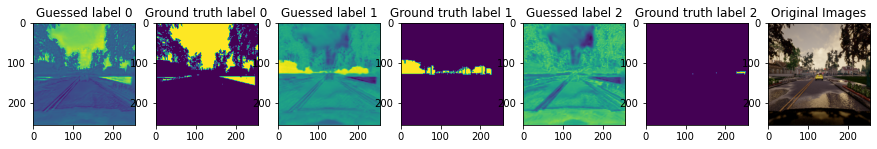

Train Epoch: 1, Loss: 0.06274381260077158
Spend time for 300 images: 149.07738065719604 sec


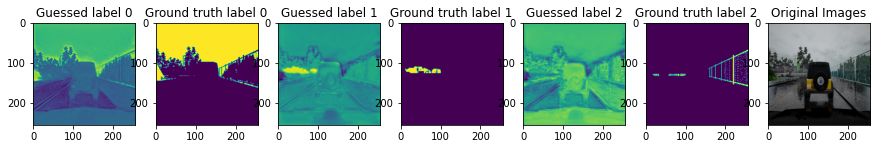

Epoch 1, loss:  0.08166955230065755


In [30]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0

            f, axarr = plt.subplots(1,7, figsize=(15,15))
            axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
            axarr[0].set_title('Guessed label 0')

            axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
            axarr[1].set_title('Ground truth label 0')

            axarr[2].imshow(outputs.detach().cpu().numpy()[0, 1, :,:])
            axarr[2].set_title('Guessed label 1')

            axarr[3].imshow(labels[0].detach().cpu().numpy()[0,1,:,:])
            axarr[3].set_title('Ground truth label 1')

            axarr[4].imshow(outputs.detach().cpu().numpy()[0, 2, :,:])
            axarr[4].set_title('Guessed label 2')

            axarr[5].imshow(labels[0].detach().cpu().numpy()[0,2,:,:])
            axarr[5].set_title('Ground truth label 2')

            axarr[6].imshow(data[0].permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:])
            axarr[6].set_title('Original Images')
            plt.show()


    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

In [ ]:
total_steps = len(test_data_loader)
total_loss = 0.
with torch.no_grad():
    for data, labels in test_data_loader:
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        outputs = Umodel(data[0])
        loss = criterion(outputs, labels[0])
        total_loss += loss

In [33]:
print(f'Loss on test dataset: {(total_loss / total_steps).item():.4f}')

Loss on test dataset: 0.0570


Сохраним нашу модель:

In [90]:
savePATH = '/selfLastModel.pth'
torch.save(Umodel.state_dict(), savePATH)

In [ ]:
net=UNet(13)
net.load_state_dict(torch.load(savePATH))

In [ ]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = Umodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
    #axarr[0].imshow(torch.argmax(outputs[0].detach().cpu().numpy()[1,:,:]))
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break